# Draw Networks for positive genes in RNA-seq data

## 1. Identification of positive genes (from 解析フォーマット)

In [139]:
# import data frame
selected_samples <- c("Y1","Y2","Y3","Y4",
                      "AWC2","AWC3","AWC4","AWC5")
e <- read.csv("count.csv",as.is=T,row=1)
e <- e[,selected_samples]
group<-c(rep("group1",4),rep("group2",4))
names(group)<-colnames(e)
Group1 = "Y1"
Group2 = "AWC"
group<-sort(group)
e<-e[,names(group)]

# import libraries
require(DT)
require(edgeR)

# remove genes with low expression
data <- e
obj <- as.logical(rowSums(data) > 0)
data <- unique(data[obj,])
data_jokyo <- data

#DEG
param_G1 <- sum(group=="group1")
param_G2 <- sum(group=="group2")
param_FDR <- 0.005
data <- data_jokyo
data.cl <- c(rep(1, param_G1), rep(2, param_G2))
d <- DGEList(counts=data,group=data.cl)
d <- calcNormFactors(d)
norm.factors <- d$samples$norm.factors/mean(d$samples$norm.factors)
ef.libsizes <- colSums(data)*norm.factors
normalized.count <- sweep(data, 2, mean(ef.libsizes)/ef.libsizes, "*")
d <- estimateCommonDisp(d) 
d <- estimateTagwiseDisp(d)
out <- exactTest(d)
p.value <- out$table$PValue
q.value <- p.adjust(p.value, method="BH")
logFC <- out$table$logFC
FC <- 2^logFC
ranking <- rank(p.value)
tmp <- cbind(rownames(data), normalized.count, p.value, q.value,logFC,FC,ranking)
upDEG <- rownames(tmp[which((tmp$p.value < param_FDR) & (tmp$FC > 1)),])
downDEG <- rownames(tmp[which((tmp$p.value < param_FDR) & (tmp$FC < 1)),])

## 2. Visualization of functional enrichment  (for upDEG)

### 2-1. import libraries

In [140]:
library(clusterProfiler)
library(enrichplot)
library(biomaRt)
library(DOSE)
library(org.Mm.eg.db)

### 2-2. convert gene symbol to entrez id

In [141]:
db <- useMart("ENSEMBL_MART_ENSEMBL")
MMusculs <- useDataset("mmusculus_gene_ensembl", mart = db)
SymbolToEntrez <- getBM(
    attributes = c("mgi_symbol", "entrezgene_id"),
    filters = "mgi_symbol",
    values = upDEG,
    mart = MMusculs
)
entrezList <- as.character(na.omit(SymbolToEntrez)[,2])

Cache found



### 2-3. KEGG pathway

### 2-3-1. barplot

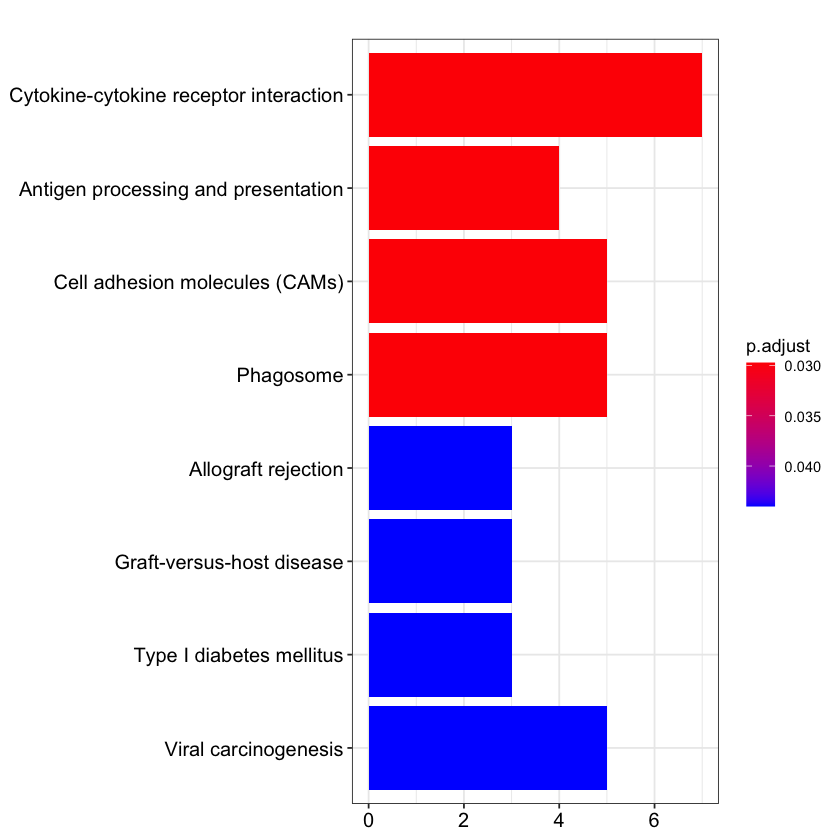

In [142]:
resKEGG <- enrichKEGG(entrezList, organism = "mmu")
barplot(resKEGG, showCategory = 10)

### 2-3-2. dotplot

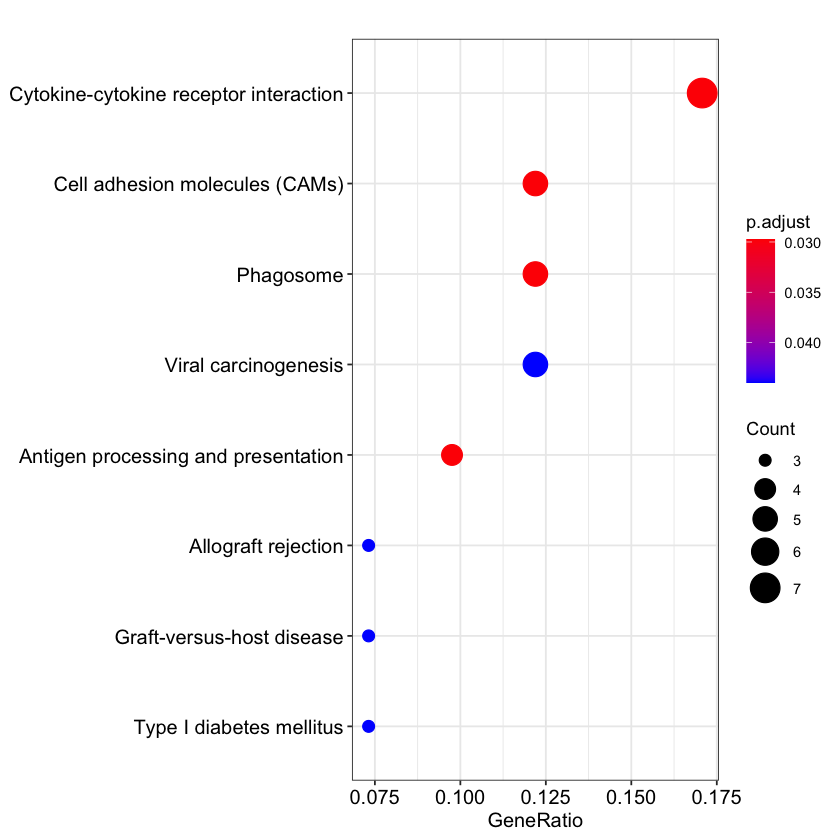

In [143]:
dotplot(resKEGG, showCategory = 10)

### 2-3-3. gene-concept network 

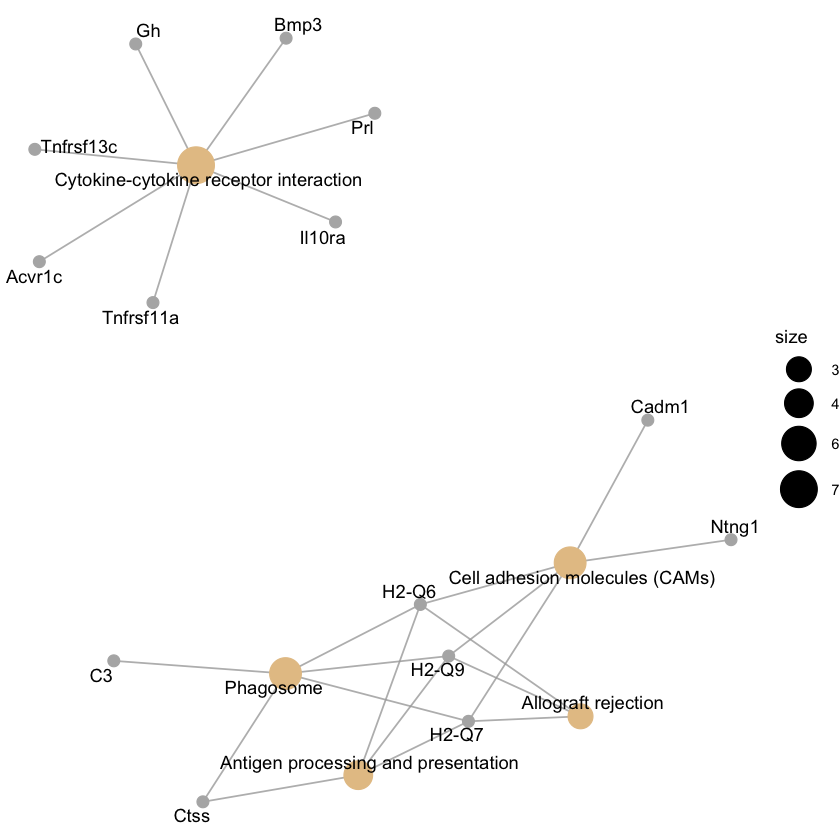

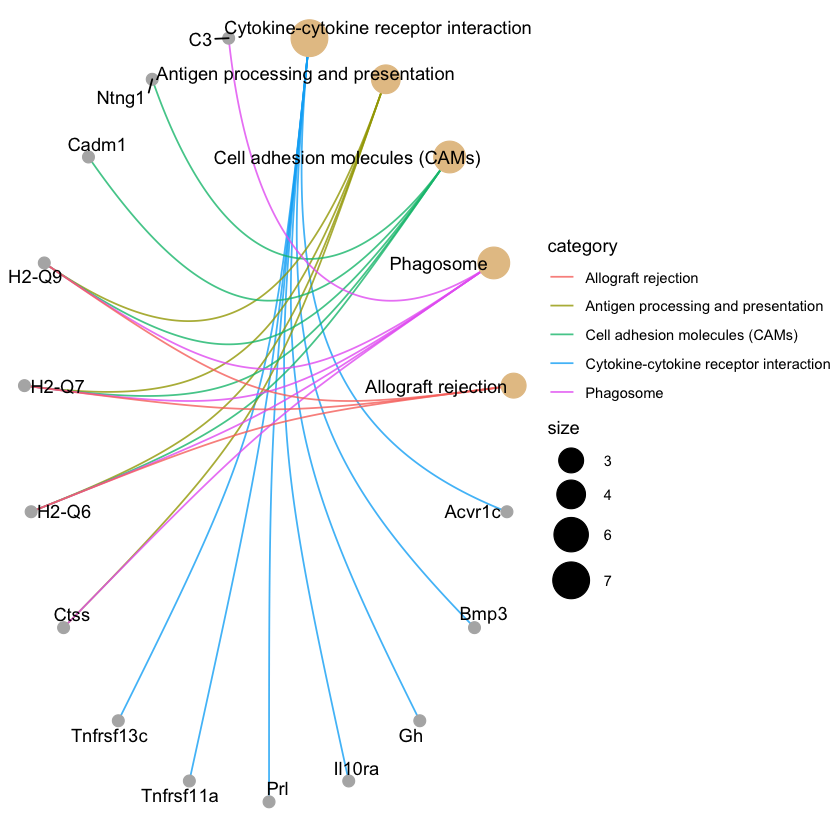

In [144]:
resKEGGEntrez <- setReadable(resKEGG, 'org.Mm.eg.db', 'ENTREZID')
p1 <- cnetplot(resKEGGEntrez, node_label="all") #foldChangeを色で反映させることができない
plot(p1)
p2 <- cnetplot(resKEGGEntrez, circular = TRUE, colorEdge = TRUE)
plot(p2)

### 2-3-4. enrichment map

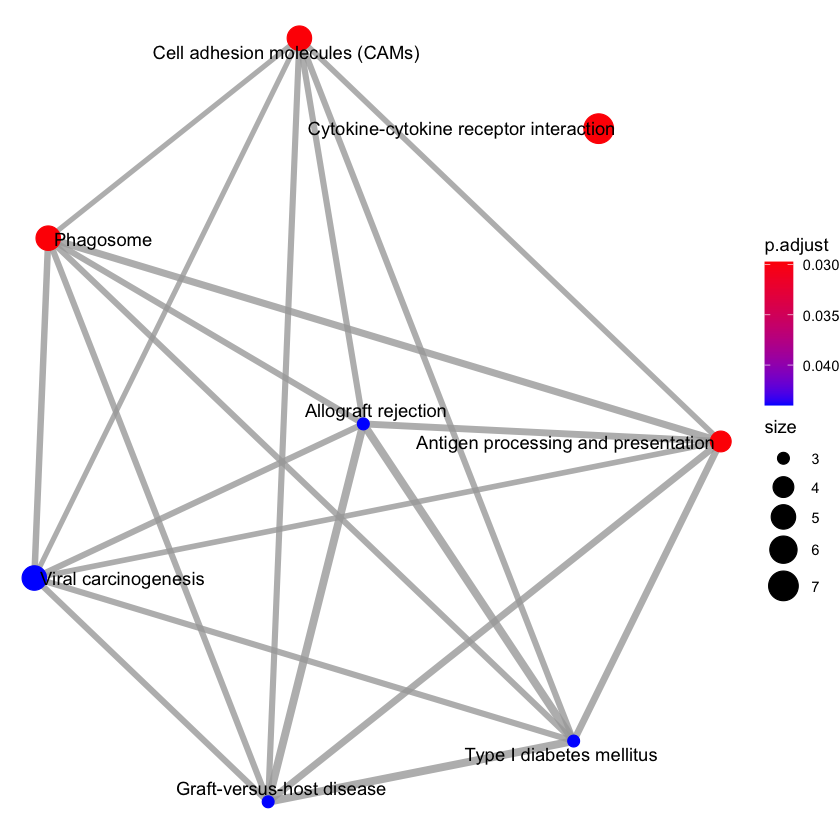

In [145]:
p3 <- emapplot(resKEGGEntrez)
plot(p3)